In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from scipy import stats
import pickle as pkl
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import cross_val_score
%matplotlib inline

In [4]:
def calc_RMSE_error(X, y, model):
    '''returns in-sample error for already fit model.'''
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    return rmse

In [5]:
with open("../data/iterate/luther_model_data_full.pkl", 'rb') as picklefile:
    sale = pkl.load(picklefile)
    
# potential zipcode filter to NW side
zips_nw = [60611, 60610, 60654, 60642,
           60622, 60647, 60614, 60657,
           60639, 60641, 60630, 60618,
           60613, 60640, 60625, 60660,
           60626, 60659, 60645]

sale_nw = sale[sale['zipcode'].isin(zips_nw)]

In [10]:
sale.dtypes

Unnamed: 0                            int64
index                                 int64
address                              object
area                                float64
bathrooms                           float64
bedrooms                            float64
city_state                           object
dates                                object
days_on_Trulia                      float64
events                               object
listing_information                  object
listing_information_date_updated     object
lot_size                            float64
lot_size_units                       object
neighborhood                         object
overview                             object
price                               float64
price_history                        object
price_per_square_foot               float64
prices                               object
public_records                       object
public_records_date_updated          object
url                             

In [ ]:
ohe(sale[""])

In [67]:
"""
build/filter/transform target and features
"""

model_params = ['price','bedrooms','bathrooms','area','median_income','year_built','duration_float']

# filter down to correlation parameters
sale = sale.dropna(subset=model_params)
model = sale[model_params]


#filter out outliers
model = model[(np.abs(stats.zscore(model)) < 1).all(axis=1)]

model['price']=model['price'].apply(np.log10)
#model['area']=model['area'].apply(np.log10)

# make data for linear regression
y = model.pop('price').values
X = StandardScaler().fit_transform(model)

In [68]:
"""
set up train test split
"""

# first split out 20% of the data as a validation set
X_training, X_validate, y_training, y_validate = train_test_split(X, y, test_size=0.2)

# now split out another 20% for cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#build initial regression model

#setting up as a polynomial but using degree 1, just to have the easy option later
degree = 1
est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
lr = LinearRegression(fit_intercept=True)

# scores_R = cross_val_score(est,
#                          X_training,
#                          y_training,
#                          cv=10)#, scoring='neg_mean_squared_error')
# scores_RMSE = cross_val_score(est,
#                          X_training,
#                          y_training,
#                          cv=10, scoring='neg_mean_squared_error')

est_fit = est.fit(X_training,y_training)
est_score = est.score(X_validate,y_validate)

print(est.named_steps['linearregression'].coef_[1:])
print(est.named_steps['linearregression'].intercept_)


[ 0.01677399  0.03107421  0.07183438  0.07733466  0.00213843 -0.07194573]
5.4211370341782095


In [69]:
calc_RMSE_error(X_validate,y_validate,est)

0.19817164798935036

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


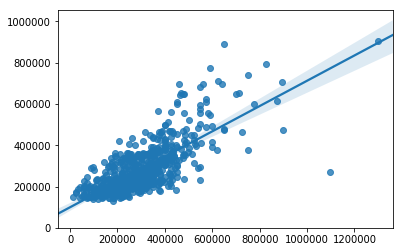

In [70]:
final = est.fit(X,y)
y_pred = final.predict(X)
ax = sns.regplot(10**y,10**y_pred)